# NLP Introduction Notebook

In this notebook we'll revise a brief introduction into Natural Language Processing using Python.

## Python libraries for NLP

There exist a few main librarires to perform NLP, those are: Wordcloud, Spacy and NLTK, so we'll first install them in our environment in the following cell. Note that for spacy we dowload english language models, those will help us in analysing Part-Of-Speech, Named Entity Recognition, Lemmatizing, and more, which we'll explain further in this notebook.

Note: If the following cell is still not installing the libraries in your environment, you can run them from the terminal (without the '!').

You can read more about them in the following links:
- Spacy: https://spacy.io/api/doc/
- NLTK: https://www.nltk.org/
- Wordcloud: https://amueller.github.io/word_cloud/

In [ ]:
# Uncomment the following lines for installing the Spacy and NLTK libraries.
# ! pip install pandas
# ! pip install wordcloud
# ! pip install nltk
# ! pip install spacy
# ! python -m spacy download en_core_web_sm
# ! python -m spacy download en_core_web_md
# ! python -m spacy download en_core_web_lg

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Now we can import the libraries. We'll also be using pandas for data importation and manipulation, and matplotlib for visualization.

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
import nltk
from nltk.corpus import stopwords
import re
# nltk.download('punkt') # Uncomment this line if using for the first time the NLTK library
# nltk.download('stopwords') # Uncomment this line if using for the first time the NLTK library

In this notebook we'll be working with the following dataset, which contains information about reviews on Amazon products: https://www.kaggle.com/datafiniti/consumer-reviews-of-amazon-products.

We will start by importing the '1429_1.csv' file which is the smallest of the three files downloaded from the Kaggle link above.

In [4]:
df = pd.read_csv("../data/archive/1429_1.csv", encoding="utf-8")

/Users/rolandotrevinolozano/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

We can observe that the amount of columns may serve for multiple types of analysis of sales on the Amazon products. For the sake of this notebook we'll focus in those that represent text information.

In [6]:
df = df[["name", "brand", "categories", "manufacturer", "reviews.date", "reviews.rating", "reviews.text", "reviews.title"]]

As the dataset covers a variety of Amazon products, we'll focus on the most reviewed one, we can obtain it from the following cell.

In [7]:
df[["name", "reviews.text"]].groupby(["name"]).count().sort_values(["reviews.text"], ascending=False).head()

,reviews.text
name,
"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",10966
"Echo (White),,,\r\nEcho (White),,,",3309
"Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,,,",3176
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",2814
"Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,",2527


Now we can filter by only the "Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta", which shows the id "AVphgVaX1cnluZ0-DR74". And now focusing on our fields that represent the reviews and their respective title.

In [8]:
df = df[df["name"] == "Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta"]
df = df[["reviews.rating", "reviews.text", "reviews.title"]]
df = df.dropna()

In order to be able to run the notebook faster, optionally we can grab a sample with a smaller amount of rows.

In [9]:
df = df.sample(n=1000, random_state=1)

The count of reviews grouped by rating:

In [51]:
df[["reviews.rating", "reviews.text"]].groupby(["reviews.rating"]).count()

,reviews.text
reviews.rating,
1.0,12
2.0,13
3.0,77
4.0,320
5.0,578


### Text Distribution

We can visualize the length of a set of texts, which first we need to get the count of words in each of the analyzed texts.

In [10]:
lista_title_count = []
lista_text_count = []
for index, row in df.iterrows():
    title_count = 0
    text_count = 0
    title_count=len((str(row['reviews.title'])))
    text_count=len((str(row['reviews.text'])))
    lista_title_count.append(title_count)
    lista_text_count.append(text_count)
    
df['title_count'] = lista_title_count
df['text_count'] = lista_text_count

In [11]:
df.head()

,reviews.rating,reviews.text,reviews.title,title_count,text_count
5976,4.0,This is a very good starter tablet. We have pu...,Amazon Fire 7 Tablet,20,167
4103,5.0,I bought it for my mom and it is perfect. It r...,Excellent,9,172
8285,5.0,"Awesome and very cheap, but would recommend!!!...",Great,5,56
13330,5.0,This tablet is perfect for an adult and kid. I...,Worth the money,15,79
11982,4.0,The Kindle Fire was a perfect gift for my wife...,Great price for a tablet,24,169


Before moving on into more specific analysis, first we will set every text to lowercase.

In [105]:
df["reviews.text"] = df["reviews.text"].str.lower()
df["reviews.title"] = df["reviews.title"].str.lower()

In the next plot, we can visualize how an average of reviews are found to have from 10 to 30 words in the title.

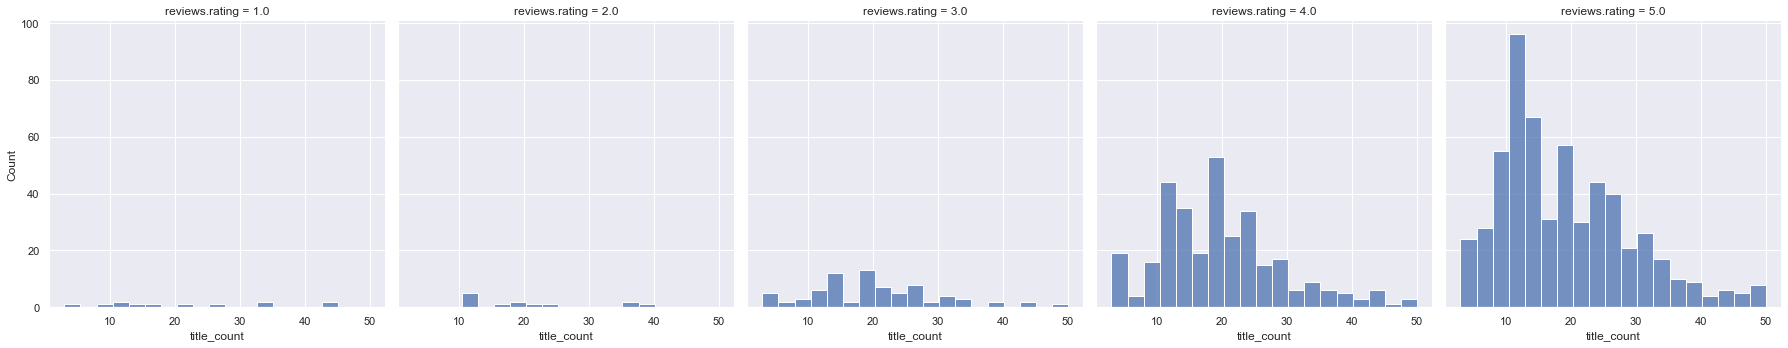

In [68]:
sns.set(rc={'figure.figsize':(12,8)})
sns.displot(df, x="title_count", col="reviews.rating")

In the next plot, we can visualize the distribution for the body texts on the reviews.

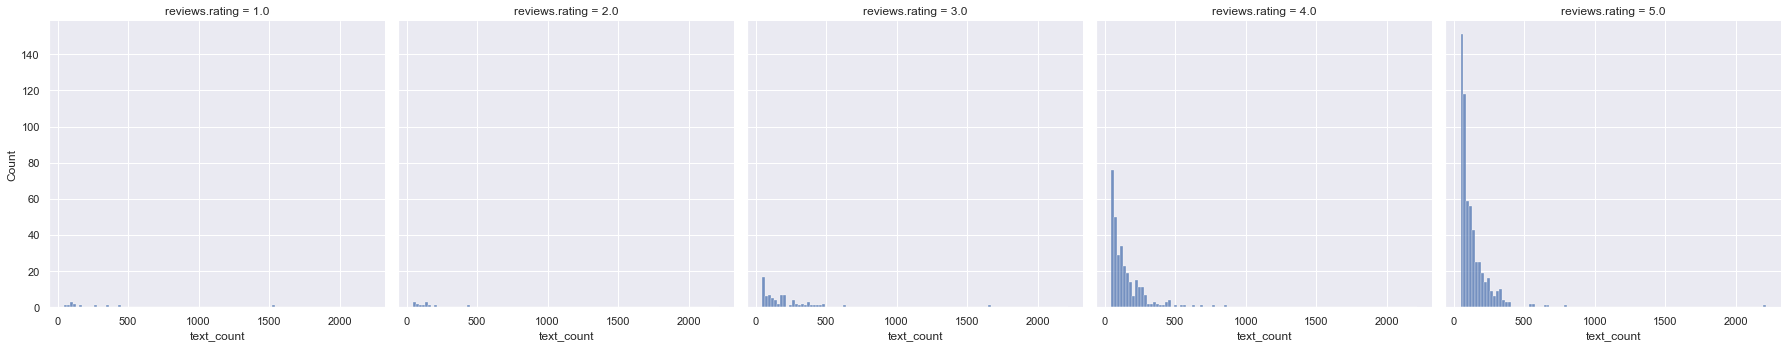

In [67]:
sns.displot(df, x="text_count", col="reviews.rating")

In the plot above we can observe that there are some reviews that are too long, we can prove that there exist these outlier reviews by plotting a box plot.

<AxesSubplot:xlabel='reviews.rating', ylabel='text_count'>

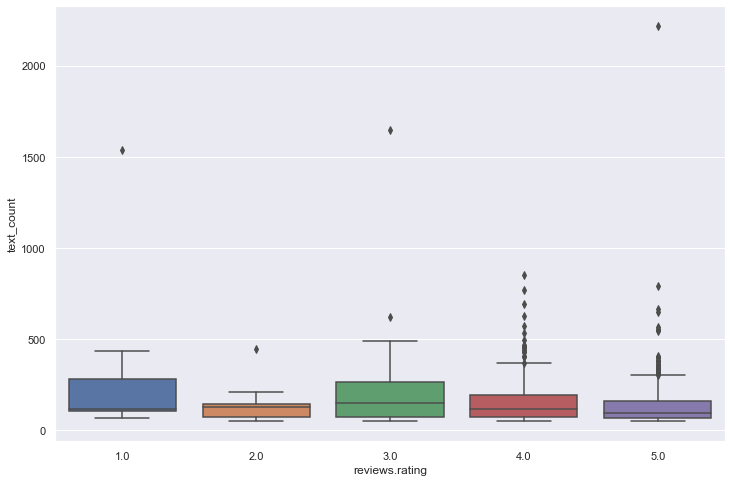

In [69]:
sns.boxplot(x="reviews.rating", y="text_count", data=df)

### Wordclouds

A wordcloud may give insight into which words are mentioned the most in a set of texts, as shown in the following example wordcloud:
<p></p>
<div>
<img src="wordcloud_example.jpg" width="500"/>
</div>

For the titles of each review we can obtain the wordcloud as shown below:

Hay 20389 palabras en titulos.


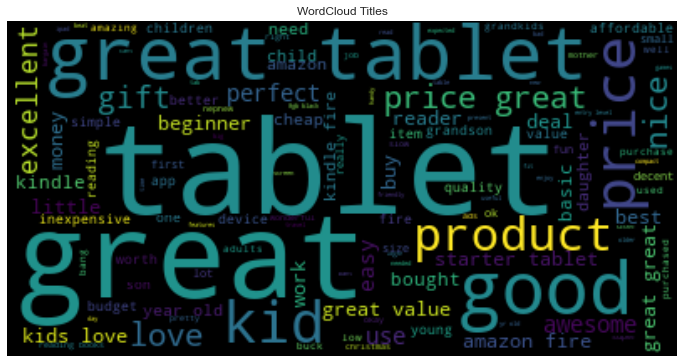

In [106]:
# Parse all the rows into a single string
title_text = " ".join(text for text in df["reviews.title"])
print ("Hay {} palabras en titulos.".format(len(title_text)))

# Generate a word cloud image:
wordcloud = WordCloud().generate(title_text)

# Display the generated image:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Titles")
plt.show()

More specifically, we could observe what the wordcloud would be like for each of the ratings in the reviews:

Hay 11580 palabras en titulos.


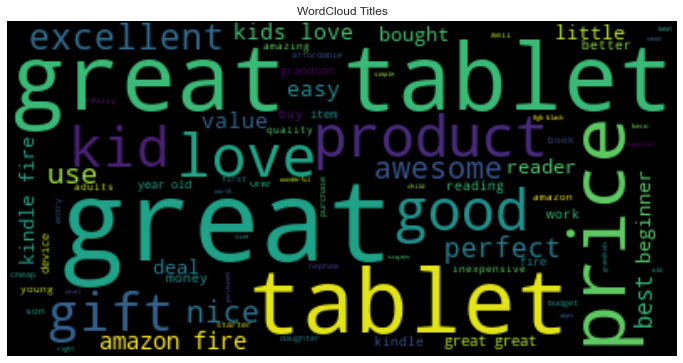

In [107]:
rating = 5.0
# Parse all the rows into a single string
title_text = " ".join(text for text in df[df["reviews.rating"] == rating]["reviews.title"])
print ("Hay {} palabras en titulos.".format(len(title_text)))

# Generate a word cloud image:
wordcloud = WordCloud().generate(title_text)

# Display the generated image:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Titles")
plt.show()

Following the same process, we can apply the same function to the reviews body texts.

Hay 148482 palabras en textos.


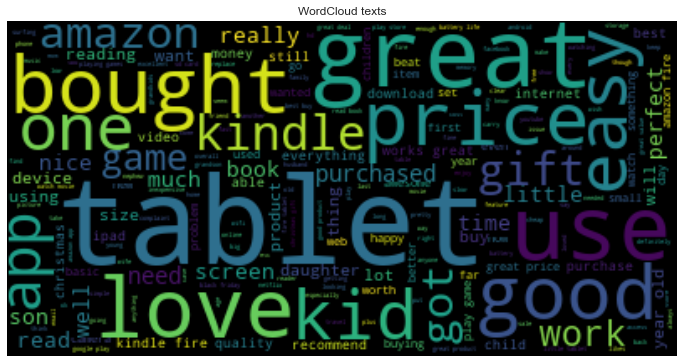

In [108]:
# Parse all the rows into a single string
body_text = " ".join(text for text in df["reviews.text"])
print ("Hay {} palabras en textos.".format(len(body_text)))

# Generate a word cloud image:
wordcloud = WordCloud().generate(body_text)

# Display the generated image:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud texts")
plt.show()

We can perform the same rating-specific approach as with the titles.

Hay 78499 palabras en textos.


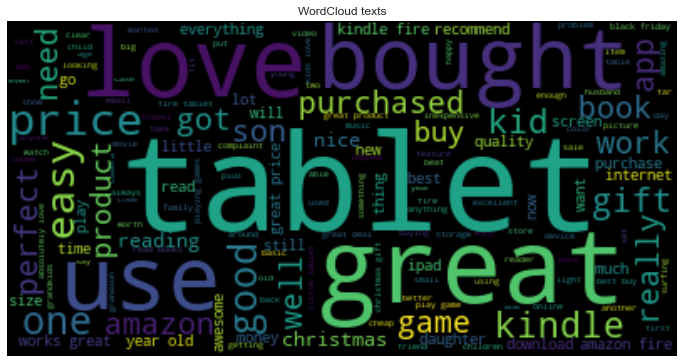

In [109]:
rating = 5.0
# Parse all the rows into a single string
body_text = " ".join(text for text in df[df["reviews.rating"] == rating]["reviews.text"])
print ("Hay {} palabras en textos.".format(len(body_text)))

# Generate a word cloud image:
wordcloud = WordCloud().generate(body_text)

# Display the generated image:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud texts")
plt.show()

### Most frequent words

Now we will introduce a couple of useful functions. 

We will being by assigning the stopwords information into the sw variable.

In [94]:
sw = stopwords.words("english")

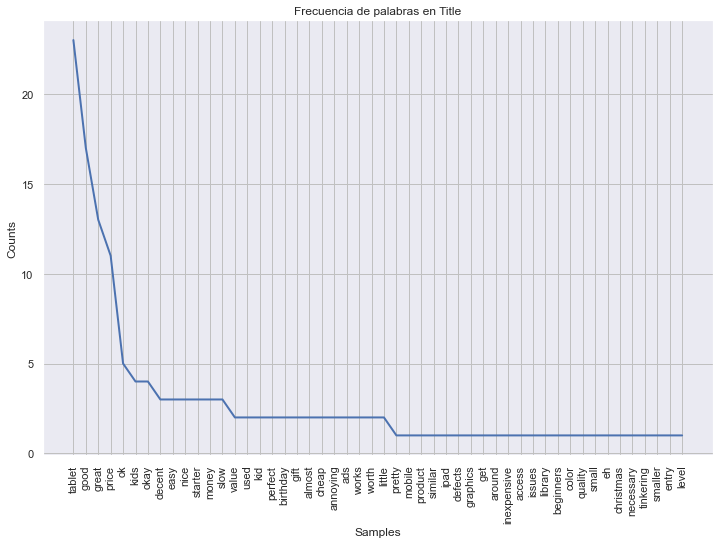

<AxesSubplot:title={'center':'Frecuencia de palabras en Title'}, xlabel='Samples', ylabel='Counts'>

In [115]:
rating = 3.0
if rating == None:
    words = " ".join(text for text in df["reviews.title"])
else:
    words = " ".join(text for text in df[df["reviews.rating"] == rating]["reviews.title"])
words = nltk.word_tokenize(words)
words = [word for word in words if word not in sw and re.match('([a-zA-Z0-9]+)',word)]
freqdist = nltk.FreqDist(words)
plt.figure(figsize=(12,8))
plt.title("Frecuencia de palabras en Title")
freqdist.plot(50)

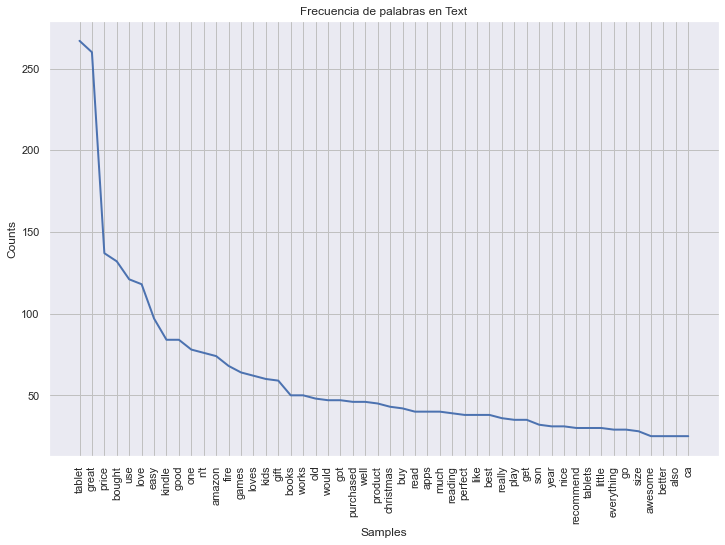

<AxesSubplot:title={'center':'Frecuencia de palabras en Text'}, xlabel='Samples', ylabel='Counts'>

In [118]:
rating = 5.0
if rating == None:
    words = " ".join(text for text in df["reviews.text"])
else:
    words = " ".join(text for text in df[df["reviews.rating"] == rating]["reviews.text"])
words = nltk.word_tokenize(words)
words = [word for word in words if word not in sw and re.match('([a-zA-Z0-9]+)',word)]
freqdist = nltk.FreqDist(words)
plt.figure(figsize=(12,8))
plt.title("Frecuencia de palabras en Text")
freqdist.plot(50)